In [18]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
import time

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import plotly.express as px

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Load the saved base models
base_model1 = load_model("ResNet50_93.15.h5")
base_model2 = load_model("InceptionV3_96.15.h5")
base_model3 = load_model("EffNetB3_71.5.h5")

In [3]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [4]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [5]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [10]:
data_dir = './Pill Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 16000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [11]:
class_names = os.listdir(data_dir)
class_names

['Alaxan',
 'Bactidol',
 'Bioflu',
 'Biogesic',
 'DayZinc',
 'Decolgen',
 'Fish Oil',
 'Kremil S',
 'Medicol',
 'Neozep']

In [12]:
class_distribution = [len(os.listdir(data_dir + "/" + name)) for name in class_names]
class_distribution

[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]

In [13]:
fig = px.pie(
    names=class_names,
    values=class_distribution,
    width=500,
    hole=0.2,
    title="Class Distribution"
)
fig.update_layout({'title':{'x':0.5}})
fig.show()

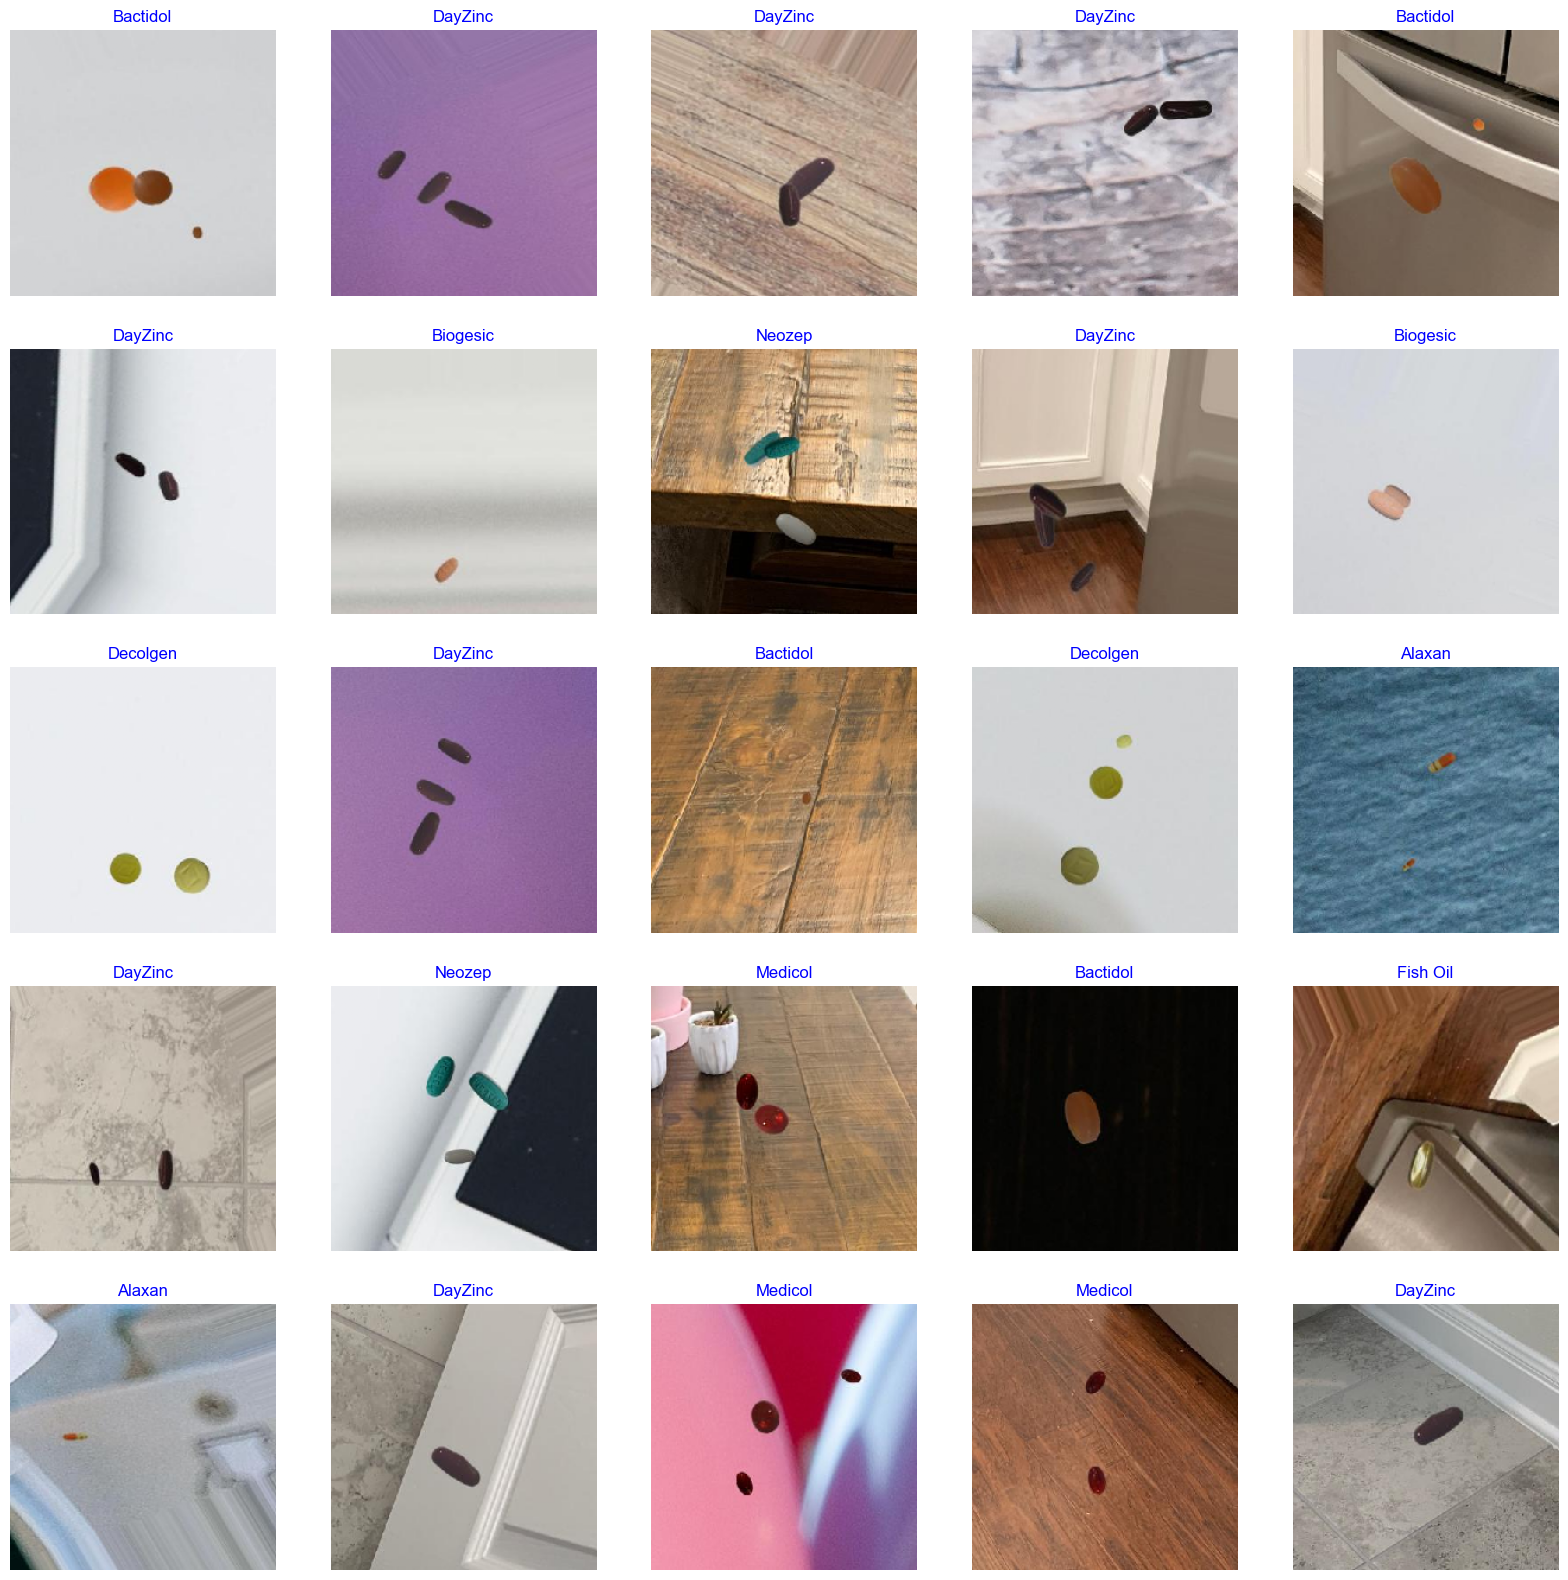

In [14]:
show_images(train_gen)

In [15]:
# Get predictions from the base models
base_model1_preds = base_model1.predict(train_gen)
base_model2_preds = base_model2.predict(train_gen)
base_model3_preds = base_model3.predict(train_gen)

400/400 [==============================] - 1173s 3s/step


In [16]:
# Combine the base model predictions into a single feature matrix
meta_features = np.concatenate((base_model1_preds, base_model2_preds, base_model3_preds), axis=1)

In [19]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)

# Record start time
start_time = time.time()

# Train the Random Forest classifier
history = rf_classifier.fit(meta_features, train_gen.labels)

# Record end time
end_time = time.time()

# Calculate training duration
training_duration = end_time - start_time
print(f"Training duration: {training_duration} seconds")

Training duration: 17.044377326965332 seconds


In [20]:
# Get predictions from the Random Forest classifier
meta_test_features = np.concatenate((base_model1.predict(test_gen),
                                     base_model2.predict(test_gen),
                                     base_model3.predict(test_gen)),
                                    axis=1)
meta_predictions = rf_classifier.predict(meta_test_features)

# Calculate metrics
test_accuracy = accuracy_score(test_gen.labels, meta_predictions)
test_recall = recall_score(test_gen.labels, meta_predictions, average='macro')
test_precision = precision_score(test_gen.labels, meta_predictions, average='macro')
test_f1 = f1_score(test_gen.labels, meta_predictions, average='macro')

print("Test Accuracy using Random Forest:", test_accuracy)
print("Test Recall using Random Forest:", test_recall)
print("Test Precision using Random Forest:", test_precision)
print("Test F1 Score using Random Forest:", test_f1)

25/25 [==============================] - 139s 6s/step
Test Accuracy using Random Forest: 0.0775
Test Recall using Random Forest: 0.07749999999999999
Test Precision using Random Forest: 0.08256141379305514
Test F1 Score using Random Forest: 0.07895152343148551


In [22]:
from sklearn.metrics import confusion_matrix

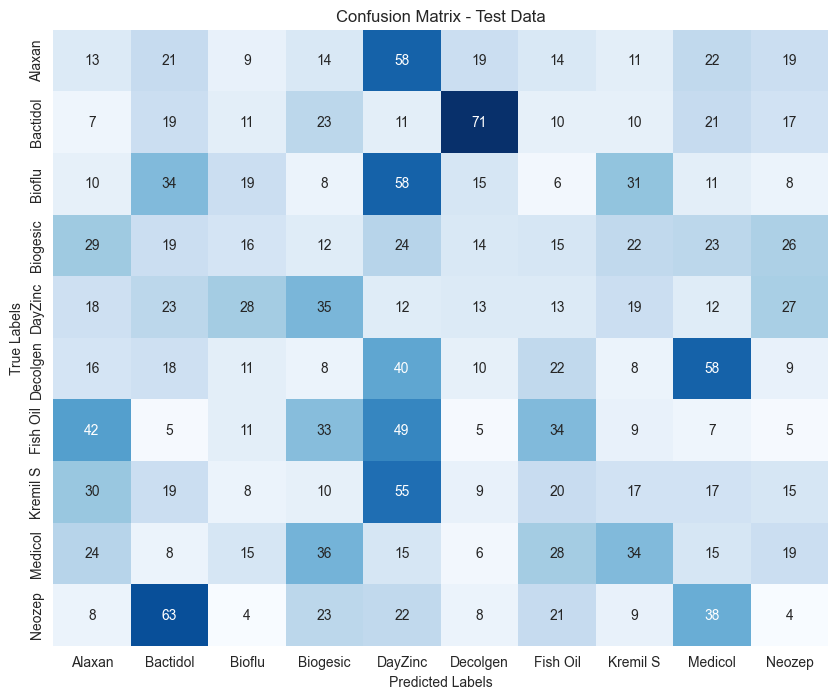

In [23]:
# Calculate the confusion matrix for test data
conf_matrix = confusion_matrix(test_gen.labels, meta_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')
plt.show()